# KIRC events per category


In [1]:
library(data.table)
library(dplyr)
library(ggplot2)
library(ggsci)
library(ggpubr)
library(ggtext)
library(matrixStats)
library(patchwork)
library(SummarizedExperiment)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count


Loading required package: MatrixGenerics


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeig

## Load data

In [17]:
res_dir <- "../input"
cancer<-"KIRC"
imp.res.file<-"../input/Figure9_KIRC.res.lfcShrink.impurity.trexCount.tsv" # Use shrunken coefficients
cond.res.file<-"../input/Figure9_KIRC.res.lfcShrink.condition.trexCount.tsv" # Use shrunken coefficients
trex.obj.file<-file.path(res_dir,cancer,"SE.eventCounts.RData")
gmapfile<-"../input/gencode.v37.primary_assembly.annotation.geneIDmap.tsv"

In [18]:
imp.ora<-fread(file = imp.res.file,data.table=F) %>%
            filter(event_flag=="valid")
tumor.ora<-fread(file = cond.res.file,data.table = F) %>%
            select(-lfcSE_condition.noCov,-stat_condition.noCov,-pvalue_condition.noCov,-signif_condition.noCov) %>%
            filter(event_flag=="valid")
load(trex.obj.file,verbose = F)
meta<-colData(trex.meta) %>% as.data.frame()
genemap<-fread(gmapfile,data.table=F)

## Stratify samples by impurity
---

In [19]:
tip<-meta %>% filter(condition=="tumor") %>% select(impurity) %>% unlist() %>% as.numeric()
low<-quantile(tip,0.1)
mid_low<-quantile(tip,0.25)
mid_high<-quantile(tip,0.5)
high<-quantile(tip,0.9)
padj_impurity<-0.05

In [20]:
meta<-meta %>%
        mutate(impurity_bin=case_when(impurity==0 ~ "normal",
                                      impurity<=low ~ "low",
                                      impurity>low & impurity<=mid_low ~ "mid_low",
                                      impurity>mid_low & impurity<=mid_high ~ "mid",
                                      impurity>mid_high & impurity<=high ~ "mid_high",
                                      impurity>high ~ "high")) %>%
        mutate(impurity_bin=factor(impurity_bin,levels=c("normal","low","mid_low","mid","mid_high","high")))
table(meta$impurity_bin)


  normal      low  mid_low      mid mid_high     high 
     144      108      162      270      430      108 

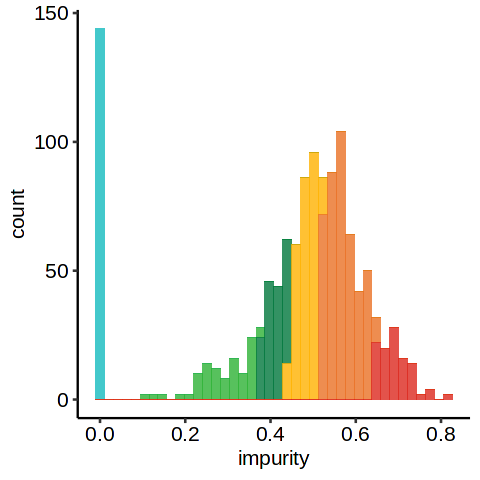

In [21]:
options(repr.plot.width=4,repr.plot.height=4)
imp.col <- c("#14BABE","#2eb135","#00773d","#ffb201","#ea7125","#dc291e") 
names(imp.col)<-levels(meta$impurity_bin)
p<-meta %>%
    ggplot(.,aes(x=impurity,fill=impurity_bin))+
        geom_histogram(,alpha=0.8,bins=40)+
        theme_pubr()+
        scale_fill_manual(values=imp.col)+
        theme(legend.position="none")
p
ggsave(plot=p,filename="../output/figures/impurity_categories.pdf",width=4,height=4,units="in",device = "pdf")
legend<-get_legend(p+theme(legend.position="top"))%>%as_ggplot(.)
ggsave(plot=legend,filename = "../output/figures/legend.impurity_categories.pdf",width = 8,height=0.5,units="in",device="pdf")

In [22]:
meta.filt<-meta%>%
           distinct(file_id,condition,stage,impurity,impurity_bin,gender,age_at_diagnosis)
evcts<-trex.meta@assays@data$abundance[unique(c(imp.ora$event_id,tumor.ora$event_id)),]
psi<-evcts[,grepl("A_",colnames(evcts))]/(evcts[,grepl("A_",colnames(evcts))]+evcts[,grepl("C_",colnames(evcts))])
psi<-log(psi/(1-psi))
psi[is.infinite(psi)|is.na(psi)]<-NA

In [23]:
for(ib in unique(meta.filt$impurity_bin)){

    bdata <- meta.filt %>%
             filter(impurity_bin==ib) %>%
             distinct(file_id)
    write.table(bdata,col.names=FALSE,row.names = FALSE,file = paste0("../output/figures/KIRC_impurity_bins/",ib,".txt"),quote=FALSE)
}

## Unbiased event filtering
---

#### Condition-associated events

In [24]:
cond.events <- tumor.ora %>%
                filter(gene_group!="NS",event_flag=="valid",abs(log2FoldChange_condition)>=1) %>%
                group_by(gene_group,direction) %>%
                arrange(padj_condition,desc(abs(log2FoldChange_condition))) %>%
                slice_min(n = 25,order_by = padj_condition) %>%
                slice_max(n = 10,order_by = abs(log2FoldChange_condition)) %>%
                distinct(gene_id,event_id,gene_group,log2FoldChange_condition,padj_condition) %>%
                rename("log2FoldChange_condition"="log2FoldChange",
                       "padj_condition"="padj") %>%
                arrange(gene_group,direction,padj,desc(abs(log2FoldChange))) %>%
                mutate(GENEID=sub("\\.\\d+","",gene_id)) %>%
                left_join(.,genemap) 

psi.cond<-psi[unique(cond.events$event_id),] %>%
           t() %>%
           as.data.frame() %>%
           mutate(sample_id=sub("A_","",colnames(psi)))%>%
           group_by(sample_id) %>%
           tidyr::pivot_longer(names_to="event_id",values_to="logitPSI",cols = unique(cond.events$event_id))%>%
           mutate(file_id=sub(".*_","",sample_id)) %>%
           ungroup() %>% 
           select(-sample_id) %>%
           left_join(.,meta.filt) %>%
           left_join(.,cond.events)

Joining, by = "GENEID"
Joining, by = "file_id"
Joining, by = "event_id"


#### Impurity-related events

In [25]:
imp.events <- imp.ora %>%
                filter(!is.na(padj_impurity),padj_impurity<0.05,event_flag=="valid",abs(log2FoldChange_impurity)>=1) %>%
                mutate(gene_group="impurity") %>%
                group_by(gene_group,direction) %>%
                arrange(padj_impurity,desc(abs(log2FoldChange_impurity))) %>%
                slice_min(n = 25,order_by = padj_impurity) %>%
                slice_max(n = 10,order_by = abs(log2FoldChange_impurity)) %>%
                distinct(gene_id,event_id,gene_group,log2FoldChange_impurity,padj_impurity)%>%
                rename("log2FoldChange_impurity"="log2FoldChange",
                       "padj_impurity"="padj") %>%
                arrange(gene_group,direction,padj,desc(abs(log2FoldChange))) %>%
                mutate(GENEID=sub("\\.\\d+","",gene_id)) %>%
                left_join(.,genemap) 

psi.imp<-psi[unique(imp.events$event_id),] %>%
           t() %>%
           as.data.frame() %>%
           mutate(sample_id=sub("A_","",colnames(psi)))%>%
           group_by(sample_id) %>%
           tidyr::pivot_longer(names_to="event_id",values_to="logitPSI",cols = unique(imp.events$event_id))%>%
           mutate(file_id=sub(".*_","",sample_id)) %>%
           ungroup() %>% 
           select(-sample_id) %>%
           left_join(.,meta.filt) %>%
           left_join(.,imp.events)

Joining, by = "GENEID"
Joining, by = "file_id"
Joining, by = "event_id"


In [26]:
psi.stats<-rbind(psi.cond,psi.imp) %>%
            group_by(impurity_bin,condition,gene_group,GENENAME,event_id) %>%
            summarize(ns=length(unique(file_id)),
                      nv=sum(!is.na(logitPSI)),
                      mean_logitPSI=mean(logitPSI,na.rm=T),
                      sdm_logitPSI=sd(logitPSI,na.rm=T)/sum(!is.na(logitPSI))) %>%
            group_by(gene_group,GENENAME,event_id) %>%
            mutate(nvalid=sum(!is.na(mean_logitPSI))) %>%
            filter(nvalid==6)

`summarise()` has grouped output by 'impurity_bin', 'condition', 'gene_group',
'GENENAME'. You can override using the `.groups` argument.


In [27]:
events_ids<-unique(psi.stats$event_id)
cts.colors<-c("#BBBABA","#8E44AD")

In [29]:
options(repr.plot.width=5,repr.plot.height=4)
for(cat in psi.stats$gene_group[1]){
    
    cat.data<-psi.stats %>% filter(gene_group==cat)
    for(ev in unique(cat.data$event_id)[1]){
        
        plot.data <- cat.data %>% filter(event_id==ev)
        gene<-unique(plot.data$GENENAME)

        nm<-plot.data %>% filter(impurity_bin=="normal") %>% ungroup %>% distinct(mean_logitPSI) %>% unlist() %>% as.numeric()
        p<-ggplot(plot.data,aes(x=impurity_bin,y=mean_logitPSI,fill=condition,group=condition))+
            geom_hline(yintercept = nm ,color="#BBBABA",linetype="dashed",linewidth=0.5)+
            geom_errorbar(aes(ymin = mean_logitPSI-sdm_logitPSI, ymax = mean_logitPSI+sdm_logitPSI),color="black", width = 0.15,linewidth=0.5,alpha=0.5)+
            geom_point(size=2,pch=21)+
            theme_pubr()+
            labs(title=gene,subtitle=sub(".*SE:","SE:",ev))+
            theme(legend.position="right",
                  plot.title=element_text(face="bold"))+
            scale_fill_manual(values=cts.colors)+
            scale_color_manual(values=cts.colors)+
            scale_x_discrete(breaks=c("normal","low","mid","high"))
        p
        ggsave(p,filename=paste0("../output/figures/event_validation_unbiased/",cat,"_",gene,"_",ev,".pdf"),width=5,height=2.5)
    }
}

In [30]:
saveRDS(psi.stats,file = "../output/objects/Figure9_psi.stats.unbiased.RDS")

## Genes matching asdb 
---

In [33]:
asdb<-fread(file="../input/ASCancer_CASE_AS_Type_hg38.csv",data.table=F) %>% select(-V1) %>%
            filter(event_type=="SE") %>%
            filter(tcga_project_id%in%c("TCGA-KIRP","TCGA-KICH","TCGA-KIRC"))
gmapfile<-"../input/gencode.v37.primary_assembly.annotation.geneIDmap.tsv"
genemap<-fread(gmapfile,data.table=F)

In [34]:
imp.events <- imp.ora %>% 
                 filter(event_flag=="valid",signif_impurity,abs(log2FoldChange_impurity)>=1) %>%
                 distinct(event_id,gene_id) %>%
                 mutate(GENEID=sub("\\..*","",gene_id),
                        event_id_org=event_id,
                        event_id=paste(GENEID,sub("ENS.*;","",event_id),sep=";")) %>%
                 left_join(.,genemap) %>%
                 rename("GENENAME"="gene_name") %>%
                 inner_join(.,asdb %>% distinct(event_id,gene_name,biological_function,functional_description)) %>%
                 ungroup() %>%
                 distinct() %>%
                 mutate(event_id = event_id_org,
                        gene_group="impurity") %>%
                 select(-event_id_org)

psi.imp<-psi[unique(imp.events$event_id),] %>%
           t() %>%
           as.data.frame() %>%
           mutate(sample_id=sub("A_","",colnames(psi)))%>%
           group_by(sample_id) %>%
           tidyr::pivot_longer(names_to="event_id",values_to="logitPSI",cols = unique(imp.events$event_id))%>%
           mutate(file_id=sub(".*_","",sample_id)) %>%
           ungroup() %>% 
           select(-sample_id) %>%
           left_join(.,meta.filt) %>%
           left_join(.,imp.events)

Joining, by = "GENEID"
Joining, by = c("event_id", "gene_name")
Joining, by = "file_id"
Joining, by = "event_id"


In [36]:
asdb.events<-fread(file = "../input/KIRC.res.condition.ascdb.match.tsv",data.table = F)
cond.events <- tumor.ora %>%
                mutate(event_id_org=event_id,
                       event_id=paste(gene_id,sub("ENS.*;","",event_id),sep=";"))%>%
                inner_join(.,asdb.events) %>%
                filter(gene_group!="NS") %>%
                mutate(event_id=event_id_org) %>%
                select(-event_id_org)

psi.cond<-psi[unique(cond.events$event_id),] %>%
           t() %>%
           as.data.frame() %>%
           mutate(sample_id=sub("A_","",colnames(psi)))%>%
           group_by(sample_id) %>%
           tidyr::pivot_longer(names_to="event_id",values_to="logitPSI",cols = unique(cond.events$event_id))%>%
           mutate(file_id=sub(".*_","",sample_id)) %>%
           ungroup() %>% 
           select(-sample_id) %>%
           left_join(.,meta.filt) %>%
           left_join(.,cond.events)

Joining, by = c("gene_id", "event_id", "gene_group")
Joining, by = "file_id"
Joining, by = "event_id"


In [37]:
psi.stats<-rbind(psi.cond[,colnames(psi.imp)],psi.imp) %>%
            group_by(impurity_bin,condition,gene_group,gene_name,event_id) %>%
            summarize(ns=length(unique(file_id)),
                      nv=sum(!is.na(logitPSI)),
                      mean_logitPSI=mean(logitPSI,na.rm=T),
                      sdm_logitPSI=sd(logitPSI,na.rm=T)/sum(!is.na(logitPSI))) %>%
            group_by(gene_group,gene_name,event_id) %>%
            mutate(nvalid=sum(!is.na(mean_logitPSI))) %>%
            filter(nvalid==6)

`summarise()` has grouped output by 'impurity_bin', 'condition', 'gene_group',
'gene_name'. You can override using the `.groups` argument.


In [39]:
options(repr.plot.width=5,repr.plot.height=4)
for(cat in psi.stats$gene_group[1]){
    
    cat.data<-psi.stats %>% filter(gene_group==cat)
    for(ev in unique(cat.data$event_id)[1]){
        
        plot.data <- cat.data %>% filter(event_id==ev)
        gene<-unique(plot.data$gene_name)

        nm<-plot.data %>% filter(impurity_bin=="normal") %>% ungroup %>% distinct(mean_logitPSI) %>% unlist() %>% as.numeric()
        p<-ggplot(plot.data,aes(x=impurity_bin,y=mean_logitPSI,fill=condition,group=condition))+
                geom_hline(yintercept = nm ,color="#BBBABA",linetype="dashed",linewidth=0.5)+
                geom_errorbar(aes(ymin = mean_logitPSI-sdm_logitPSI, ymax = mean_logitPSI+sdm_logitPSI),color="black", width = 0.15,linewidth=0.5,alpha=0.5)+
                geom_point(size=2,pch=21)+
                theme_pubr()+
                labs(title=gene,subtitle=sub(".*SE:","SE:",ev))+
                theme(legend.position="right",
                      plot.title=element_text(face="bold"))+
                scale_fill_manual(values=cts.colors)+
                scale_color_manual(values=cts.colors)+
                scale_x_discrete(breaks=c("normal","low","mid","high"))

        
        ggsave(p,filename=paste0("../output/figures/event_validation_ascdb/",cat,"_",gene,"_",ev,".pdf"),width=5,height=2.5)
    }
}

In [40]:
saveRDS(psi.stats,file = "../output/objects/psi.stats.ascdb.RDS")